<a href="https://colab.research.google.com/github/SDS-AAU/dsba-cbs/blob/master/M3/workshop/SimpleRNN_stocks_multiple_steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time series prediction with LSTMs
This notebook is adopted from [Machine Learning Mastery](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
Please visit the tutorial there for more details and to see variations of that using sliding windows and timesteps.




In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [16]:
!pip install pandas-datareader

In [3]:
from pandas_datareader import data as pdr

In [4]:
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

# download dataframe
data = pdr.get_data_yahoo("^OMXH25", start="2017-12-01", end="2020-12-01")

[*********************100%***********************]  1 of 1 completed


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 748 entries, 2017-12-01 to 2020-11-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       748 non-null    float64
 1   High       748 non-null    float64
 2   Low        748 non-null    float64
 3   Close      748 non-null    float64
 4   Adj Close  748 non-null    float64
 5   Volume     748 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 40.9 KB


In [6]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,3914.330078,3915.100098,3872.439941,3874.820068,3874.820068,0
2017-12-04,3879.229980,3911.550049,3879.229980,3892.010010,3892.010010,0
2017-12-05,3889.620117,3913.209961,3877.510010,3887.729980,3887.729980,0
2017-12-06,3889.620117,3913.209961,3877.510010,3887.729980,3887.729980,0
2017-12-07,3884.810059,3895.649902,3863.040039,3864.179932,3864.179932,0
...,...,...,...,...,...,...
2020-11-24,4525.390137,4562.390137,4524.549805,4560.370117,4560.370117,0
2020-11-25,4574.439941,4594.890137,4558.290039,4575.080078,4575.080078,0
2020-11-26,4584.689941,4589.129883,4554.410156,4567.640137,4567.640137,31518700


In [12]:
data_diff = data.diff()

In [13]:
import numpy
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [14]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [15]:
# normalizing
scaler = MinMaxScaler(feature_range=(-1, 1))
data_diff['Adj_Close_scaled'] = scaler.fit_transform(data_diff['Adj Close'].values.reshape(-1, 1))

In [16]:
data_diff

,Open,High,Low,Close,Adj Close,Volume,Adj_Close_scaled
Date,,,,,,,
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-04,-35.100098,-3.550049,6.790039,17.189941,17.189941,0.0,0.339561
2017-12-05,10.390137,1.659912,-1.719971,-4.280029,-4.280029,0.0,0.262271
2017-12-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.277678
2017-12-07,-4.810059,-17.560059,-14.469971,-23.550049,-23.550049,0.0,0.192900
...,...,...,...,...,...,...,...
2020-11-24,18.990234,36.439941,24.779785,53.560059,53.560059,0.0,0.470490
2020-11-25,49.049805,32.500000,33.740234,14.709961,14.709961,0.0,0.330633
2020-11-26,10.250000,-5.760254,-3.879883,-7.439941,-7.439941,31518700.0,0.250895


In [77]:
# get the data as matrix
data_p = data_diff.iloc[1:,6].values.astype('float32')

In [78]:
data_p = data_p.reshape(-1,1)

In [79]:
# split into train and test sets
train_size = int(len(data_p) * 0.67)
test_size = len(data_p) - train_size
train, test = data_p[:train_size], data_p[train_size:len(data_p)]
print(len(train), len(test))

500 247


In [80]:
# reshape into X=t and Y=t+1
look_back = 10
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [81]:
X_train

array([[0.3395605 , 0.26227063, 0.27767834, ..., 0.367676  , 0.1873933 ,
        0.2918257 ],
       [0.26227063, 0.27767834, 0.19290037, ..., 0.1873933 , 0.2918257 ,
        0.4267141 ],
       [0.27767834, 0.19290037, 0.36681205, ..., 0.2918257 , 0.4267141 ,
        0.27685043],
       ...,
       [0.39690766, 0.21064767, 0.210072  , ..., 0.2646832 , 0.28207013,
        0.25543028],
       [0.21064767, 0.210072  , 0.26410663, ..., 0.28207013, 0.25543028,
        0.21482413],
       [0.210072  , 0.26410663, 0.19502464, ..., 0.25543028, 0.21482413,
        0.10301083]], dtype=float32)

In [82]:
X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [83]:
# build the network

model = Sequential()
model.add(LSTM(16, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [84]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 10, 16)            1152      
_________________________________________________________________
lstm_11 (LSTM)               (None, 4)                 336       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 1,493
Trainable params: 1,493
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
489/489 - 2s - loss: 0.0203
Epoch 2/10
489/489 - 2s - loss: 0.0185
Epoch 3/10
489/489 - 2s - loss: 0.0188
Epoch 4/10
489/489 - 2s - loss: 0.0185
Epoch 5/10
489/489 - 2s - loss: 0.0185
Epoch 6/10
489/489 - 2s - loss: 0.0184
Epoch 7/10
489/489 - 2s - loss: 0.0180
Epoch 8/10
489/489 - 2s - loss: 0.0184
Epoch 9/10
489/489 - 2s - loss: 0.0184
Epoch 10/10
489/489 - 2s - loss: 0.0180


In [86]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [87]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])

testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [88]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 37.33 RMSE
Test Score: 67.26 RMSE


In [89]:
data_diff['Adj_close_pred'] = data_diff['Adj Close']

In [90]:
testPredict.shape

(236, 1)

In [91]:
data_diff['Adj_close_pred'].iloc[-236:] = testPredict.flatten()

In [92]:
data_diff['Adj_close_pred']

Date
2017-12-01          NaN
2017-12-04    17.189941
2017-12-05    -4.280029
2017-12-06     0.000000
2017-12-07   -23.550049
                ...    
2020-11-24    -1.878167
2020-11-25    -2.150998
2020-11-26    -2.049402
2020-11-27    -2.150865
2020-11-30    -2.208170
Name: Adj_close_pred, Length: 748, dtype: float64

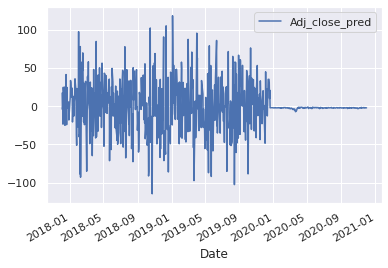

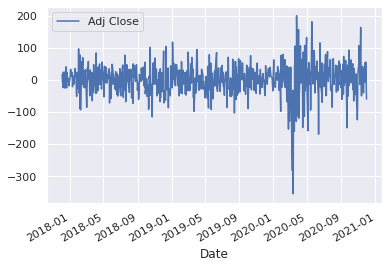

In [93]:
data_diff.loc[:,['Adj_close_pred']].plot()
data_diff.loc[:,['Adj Close']].plot()